In [28]:
import pandas as pd
from bs4 import BeautifulSoup as bs
from selenium import webdriver
import mplfinance as mpf
import time
import warnings

warnings.filterwarnings('ignore')
timeS=time.time()


code='005930'

url=f'https://finance.naver.com/item/sise_day.nhn?code={code}&page='
print(url)

driver = webdriver.Chrome('../../chromedriver/chromedriver.exe')
driver.get(url+'1')
html = bs(driver.page_source, 'html.parser')
endPage=html.find('td', class_="pgRR").find('a')['href'].split('=')[-1]

nav_finance=[]

columns = html.find('tr').text.strip().split('\n')

for page in range(1, 31):
    driver.get(url+str(page))
    html = bs(driver.page_source, 'html.parser')
    time.sleep(3)
    soup_tr=html.find_all('tr')
    
    for i in range(2, 15):
        day_data = []
        soup_td = soup_tr[i].find_all('td')
        if len(soup_td) < 7:
            continue
        for data in soup_td:
            day_data.append(data.text.strip().replace(',', ''))
            
        nav_finance.append(day_data)

driver.close()

https://finance.naver.com/item/sise_day.nhn?code=005930&page=


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   날짜      300 non-null    datetime64[ns]
 1   종가      300 non-null    int32         
 2   전일비     300 non-null    int32         
 3   시가      300 non-null    int32         
 4   고가      300 non-null    int32         
 5   저가      300 non-null    int32         
 6   거래량     300 non-null    int32         
dtypes: datetime64[ns](1), int32(6)
memory usage: 9.5 KB
None
            날짜     종가   전일비     시가     고가     저가       거래량
295 2021-02-05  83500  1000  83100  84000  82500  18036835
296 2021-02-04  82500  2100  83500  83800  82100  24171688
297 2021-02-03  84600   200  84800  85400  83400  22112205
298 2021-02-02  84400  1400  84100  86400  83700  26302077
299 2021-02-01  83000  1000  81700  83400  81000  28046832


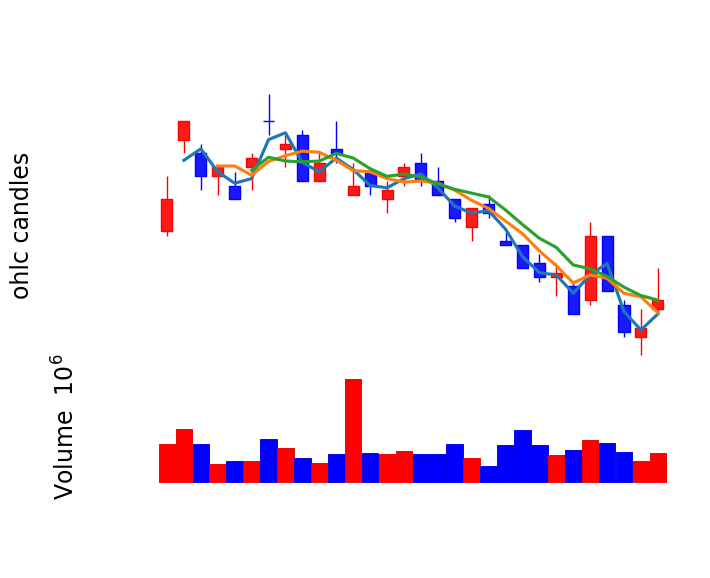

In [33]:
df=pd.DataFrame(nav_finance, columns=columns)
df=df.dropna()  # None(NaN) 값 제거

df['날짜']=pd.to_datetime(df['날짜'])
df=df.astype({'종가':'int',"전일비":'int','시가':'int','고가':'int','저가':'int','거래량':'int'})

print(df.info())
print(df.tail())

df.to_csv('./data/삼성전자.csv', index=False)
df=df.iloc[:30]

df = df.rename(columns={'날짜':'Date', '시가':'Open', '고가':'High', '저가':'Low', '종가':'Close', '거래량':'Volume'})
df = df.sort_values(by='Date')
df.index = pd.to_datetime(df.Date)
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]

#mpf.plot(df, title='Celltrion candle chart', type='candle')
#mpf.plot(df, title='Celltrion ohlc chart', type='ohlc')

kwargs = dict(title='Celltrion customized chart', type='candle',
              mav=(2, 4, 6), volume=True, ylabel='ohlc candles')

mc = mpf.make_marketcolors(up='r', down='b', inherit=True)
s  = mpf.make_mpf_style(marketcolors=mc)
mpf.plot(df, **kwargs, style=s)

In [34]:
import pymysql as mysql
from IPython.core.display import display, HTML
warnings.filterwarnings('ignore')
display(HTML("<style>.cm-s-ipython span.cm-comment { color: yellow; }</style>"))


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30 entries, 2022-03-08 to 2022-04-19
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Open    30 non-null     int32
 1   High    30 non-null     int32
 2   Low     30 non-null     int32
 3   Close   30 non-null     int32
 4   Volume  30 non-null     int32
dtypes: int32(5)
memory usage: 840.0 bytes


In [45]:
df = pd.read_csv('./data/삼성전자.csv')
df = df[['종가', '고가', '저가', '시가', '거래량']]

In [46]:
times = time.time()

conn = mysql.connect(host='127.0.0.1', user='root', password='root', database='test', 
                     port=3306, autocommit=True)

cur = conn.cursor()

sql_list = []

for i in range(len(df)):
    sql_list.append((df.iloc[i, 0], df.iloc[i, 1],
                     df.iloc[i, 2], df.iloc[i, 3],
                     df.iloc[i, 4]))

sql = 'insert into jusik values(%s, %s, %s, %s, %s)'
cur.executemany(sql, sql_list)
    
print(time.time() - times)
conn.commit()
conn.close()

0.04860377311706543
